In [1]:
from PIL import Image, ImageOps                   
import numpy as np                     
import os
import matplotlib.pyplot as plt      
plt.style.use("ggplot")

D:\python38\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
D:\python38\lib\site-packages\numpy\.libs\libopenblas.4SP5SUA7CBGXUEOC35YP2ASOICYYEQZZ.gfortran-win_amd64.dll
D:\python38\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
D:\python38\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
D:\python38\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
def img_data(imgPath,disp = True):
    
    orig_img = Image.open(imgPath)
    
    img_size_kb = os.stat(imgPath).st_size/1024
    
    ori_pixels = np.array(orig_img.getdata()).reshape(*orig_img.size, -1)
    
    img_dim = ori_pixels.shape 
    
    if disp:
        plt.imshow(orig_img)
        plt.show()
    
    data_dict = {}
    data_dict['img_size_kb'] = img_size_kb
    data_dict['img_dim'] = img_dim
    
    return data_dict

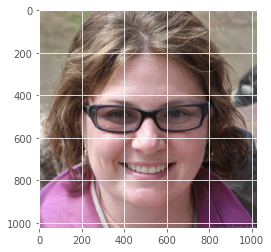

Original Image Data
Original Image size (kB) 585.455078125
Original Image Shape (1024, 1024, 3)


In [37]:
imgPath = 'test1.jpg';

data_dict_ori = img_data(imgPath)

print('Original Image Data')
print('Original Image size (kB)',data_dict_ori['img_size_kb'])
print('Original Image Shape',data_dict_ori['img_dim'])

In [38]:
from sklearn.decomposition import PCA

def pca_compose(imgPath):
    
    orig_img = Image.open(imgPath)
    img = np.array(orig_img.getdata())
    img = img.reshape(*orig_img.size, -1)
    pca_channel = {}
    img_t = np.transpose(img) 
    
    for i in range(img.shape[-1]):    
        
        per_channel = img_t[i] 
        
        channel = img_t[i].reshape(*img.shape[:-1])  
        
        pca = PCA(random_state = 42)                
        
        fit_pca = pca.fit_transform(channel)        
        
        pca_channel[i] = (pca,fit_pca)  
        
    return pca_channel

In [39]:
pca_channel = pca_compose(imgPath)

In [40]:
len(pca_channel)

3

In [41]:
def explained_var_n(pca_channel, n_components):
    
    var_exp_channel = []; var_exp=0
    
    for channel in pca_channel:
        
        pca,_ = pca_channel[channel]
        
        var_exp_channel.append(np.cumsum(pca.explained_variance_ratio_))
        
        var_exp += var_exp_channel[channel][n_components]
        
    var_exp = var_exp/len(pca_channel)
    
    return var_exp

In [42]:
var_exp = explained_var_n(pca_channel, 1023)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  99.99999999999999 %


In [43]:
def variance_added_pc(pca_channel):
    
    var_exp_channel = [];var_exp=0;
    
    for channel in pca_channel:
        pca,_ = pca_channel[channel]
        var_exp_channel.append(pca.explained_variance_ratio_)
        
    var_exp = (var_exp_channel[0]+var_exp_channel[1]+var_exp_channel[2])/3
    
    x = list(var_exp);y = list(range(1,1+len(x)));y = list(range(1,21))
    
    plt.yticks(np.arange(0, max(x)+0.05,0.05))
    plt.xticks(np.arange(min(y), max(y)+1,1))
    plt.title("Individual Variance for each Principal Component")
    plt.ylabel('Variance')
    plt.xlabel('Principal Component');
    plt.bar(y,x[:20],color = 'black')
    plt.show()

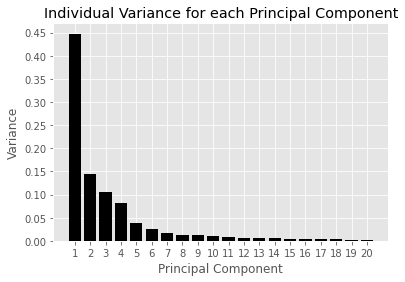

In [44]:
variance_added_pc(pca_channel)

In [45]:
def plot_variance_pc(pca_channel):
    
    pca,fit_pca = pca_channel[0]
    
    exp_var = {}
    
    for i in range(len(pca.components_)):
        var_exp = explained_var_n(pca_channel,i)
        exp_var[i+1] = var_exp
    
    lists = sorted(exp_var.items()) 
    
    x, y = zip(*lists) 
    
    pt90 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.9)
    pt95 = next(xx[0] for xx in enumerate(y) if xx[1] > 0.95)
    
    plt.plot(x, y)
    plt.vlines(x=x[pt90], ymin=0, ymax=y[pt90], colors='green',  ls=':', lw=2, label=str('90% Variance Explained : n = '+str(x[pt90])))
    plt.vlines(x=x[pt95], ymin=0, ymax=y[pt95], colors='red', ls=':', lw=2, label=str('95% Variance Explained : n = '+str(x[pt95])))
    
    plt.xticks(np.arange(min(x)-1, max(x)-1,100))
    plt.yticks(np.arange(0, max(y),0.1))
    
    plt.legend(loc="lower right")
    plt.title("Variance vs Principal Components")
    plt.xlabel("Principal Components")
    plt.ylabel("Variance Explained")
    plt.grid(True)
    plt.show()

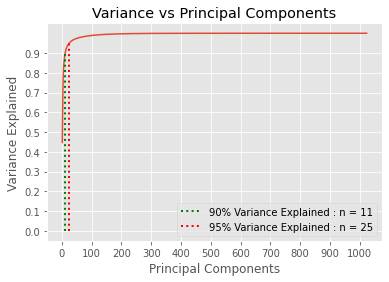

In [46]:
plot_variance_pc(pca_channel)

In [56]:
n_components = 120

var_exp = explained_var_n(pca_channel, n_components)

print("Explained variance in percentage by PCA : ", var_exp*100,"%")

Explained variance in percentage by PCA :  99.18513966096009 %


In [57]:
def pca_transform(pca_channel, n_components):
    
    temp_res = []
    
    for channel in range(len(pca_channel)):
        
        pca, fit_pca = pca_channel[channel]
        
        pca_pixel = fit_pca[:, :n_components]
        
        pca_comp = pca.components_[:n_components, :]
        
        compressed_pixel = np.dot(pca_pixel, pca_comp) + pca.mean_
        
        temp_res.append(compressed_pixel)
            
    compressed_image = np.transpose(temp_res)
    
    compressed_image = np.array(compressed_image,dtype=np.uint8)
    
    return compressed_image

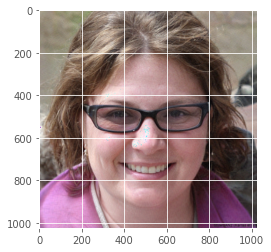

In [58]:
compressed_image = pca_transform(pca_channel,n_components=n_components)

plt.imshow(compressed_image)
plt.show()

Image.fromarray(compressed_image).save("compressed_img.jpeg")

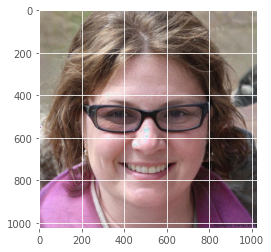

Compressed Image Data
Compressed Image size (kB) 113.22265625
Compression Percentage 80.66074401257035 %
Compressed Image Shape (1024, 1024, 3)


In [59]:
imgPath = 'compressed_img.jpeg';

data_dict_comp = img_data(imgPath)

print('Compressed Image Data')
print('Compressed Image size (kB)',data_dict_comp['img_size_kb'])
print('Compression Percentage', 100 - (data_dict_comp['img_size_kb']/data_dict_ori['img_size_kb'])*100,'%')
print('Compressed Image Shape',data_dict_comp['img_dim'])